# Exploring feature selection strategies to monitor model performance

In this notebook we are going to try employing different feature selection strategies in an existing pipeline and try to understand its impact on performance of different models.

# Streamline model fit and validation

In order to compare the performance of different models, let's streamline the transformation, fit and prediction steps.

In [11]:
# Our training and validation features and target labels were prepared before:
import pickle
with open("X_val1.pkl","rb") as f:
    X_train = pickle.load(f)   
with open("y_val1.pkl","rb") as f:
    y_train = pickle.load(f)
        
with open("X_val2.pkl","rb") as f:
    X_val = pickle.load(f)       
with open("y_val2.pkl","rb") as f:
    y_val = pickle.load(f)    

In [ ]:
# Write a function to streamline classifiers
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from datetime import datetime
import warnings
import pandas as pd
warnings.filterwarnings("ignore")


def calculate_validation(X_val_trans,y_val,clf):
    probs = clf.predict_proba(X_val_trans)[:,1]
    return roc_auc_score(y_val,probs)


def streamline_classifiers(fpipeline,nfeatures,X_train,y_train,X_val,y_val):
    """ We will monitor performance of different default classifiers."""
    print(">>> streamline_classifiers: started exploring model performance using " + str(nfeatures) + " features.")
    # Transform the training and test set using the current pipeline
    start = datetime.now()
    X_train_trans = fpipeline.fit(X_train,y_train).transform(X_train)
    process = datetime.now() - start
    print(" >>> streamline_classifiers: fitted and transformed X_train. It took: " + str(process.seconds/60) + " minutes.")
    print("Shape of X_train is " + str(X_train_trans.shape))
    start = datetime.now()
    X_val_trans = fpipeline.transform(X_val)
    process = datetime.now() - start
    print(" >>> streamline_classifiers: transformed X_val. It took: " + str(process.seconds/60) + " minutes.")
    print("Shape of X_val is " + str(X_val_trans.shape))
    #######################################################################
    # Train different classifiers report and calculate the validation score
    #######################################################################
    # LogisticRegression
    clf_dict = {
        "LogisticRegression": LogisticRegression(),
        "MultinomialNB":MultinomialNB(),
        "AdaBoostClassifier":AdaBoostClassifier(),
        "QuadraticDiscriminantAnalysis":QuadraticDiscriminantAnalysis()
    }
    
    # Container to collect current scores
    scores = pd.DataFrame()
    scores["nfeatures"] = pd.Series(nfeatures)
    
    for key,value in clf_dict.items():
        start = datetime.now()
        
        clf = value
        clf.fit(X_train_trans,y_train)
        val_score =calculate_validation(X_val_trans,y_val,clf)
        scores[key] = pd.Series(val_score)
        
        process = datetime.now() - start
        print(" >>> Completed " +str(key) + " classifier with an roc score of "+str(val_score) + " it took " +str(process.seconds/60)+ " minutes." )
        print("*" * 80)
    # Return a data frame of validation roc scores for a given number of features
    return scores



In [13]:
# Label text features
Text_features = ["app","device","os","channel"]

##############################################################
# Define utility function to parse and process text features
##############################################################
# Note we avoid lambda functions since they don't pickle when we want to save the pipeline later   
def column_text_processer_nolambda(df,text_columns = Text_features):
    import pandas as pd
    import numpy as np
    """"A function that will merge/join all text in a given row to make it ready for tokenization. 
    - This function should take care of converting missing values to empty strings. 
    - It should also convert the text to lowercase.
    df= pandas dataframe
    text_columns = names of the text features in df
    """ 
    # Select only non-text columns that are in the df
    text_data = df[text_columns]
    
    # Fill the missing values in text_data using empty strings
    text_data.fillna("",inplace=True)
    
    # Concatenate feature name to each category encoding for each row
    # E.g: encoding 3 at device column will read as device3 to make each encoding unique for a given feature
    for col_index in list(text_data.columns):
        text_data[col_index] = col_index + text_data[col_index].astype(str)
    
    # Join all the strings in a given row to make a vector
    # text_vector = text_data.apply(lambda x: " ".join(x), axis = 1)
    text_vector = []
    for index,rows in text_data.iterrows():
        text_item = " ".join(rows).lower()
        text_vector.append(text_item)

    # return text_vector as pd.Series object to enter the tokenization pipeline
    return pd.Series(text_vector)

#######################################################################
# Define custom processing functions to add the log_total_clicks and 
# log_total_click_time features, and remove the unwanted base features
#######################################################################
def column_time_processer(X_train):
    import pandas as pd
    import numpy as np

    # Convert click_time to datetime64 dtype 
    X_train.click_time = pd.to_datetime(X_train.click_time)

    # Calculate the log_total_clicks for each ip and add as a new feature to temp_data
    temp_data = pd.DataFrame(np.log(X_train.groupby(["ip"]).size()),
                                    columns = ["log_total_clicks"]).reset_index()


    # Calculate the log_total_click_time for each ip and add as a new feature to temp_data
    # First define a function to process selected ip group 
    def get_log_total_click_time(group):
        diff = (max(group.click_time) - min(group.click_time)).seconds
        return np.log(diff+1)

    # Then apply this function to each ip group and extract the total click time per ip group
    log_time_frame = pd.DataFrame(X_train.groupby(["ip"]).apply(get_log_total_click_time),
                                  columns=["log_total_click_time"]).reset_index()

    # Then add this new feature to the temp_data
    temp_data = pd.merge(temp_data,log_time_frame, how = "left",on = "ip")

    # Combine temp_data with X_train to maintain X_train key order
    temp_data = pd.merge(X_train,temp_data,how = "left",on = "ip")

    # Drop features that are not needed
    temp_data = temp_data[["log_total_clicks","log_total_click_time"]]

    # Return only the numeric features as a tensor to integrate into the numeric feature branch of the pipeline
    return temp_data


#############################################################################
# We need to wrap these custom utility functions using FunctionTransformer
from sklearn.preprocessing import FunctionTransformer
# FunctionTransformer wrapper of utility functions to parse text and numeric features
# Note how we avoid putting any arguments into column_text_processer or column_time_processer
#############################################################################
get_numeric_data = FunctionTransformer(func = column_time_processer, validate=False) 
get_text_data = FunctionTransformer(func = column_text_processer_nolambda,validate=False) 

#############################################################################
# Create the token pattern: TOKENS_ALPHANUMERIC
# #Note this regex will match either a whitespace or a punctuation to tokenize 
# the string vector on these preferences, in our case we only have white spaces in our text  
#############################################################################
TOKENS_ALPHANUMERIC = '[A-Za-z0-9]+(?=\\s+)'  

In [46]:
######################################################
# Construct our feature extraction selection pipeline
######################################################
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MaxAbsScaler, Imputer
from sklearn.feature_selection import SelectKBest,VarianceThreshold, chi2,SelectFromModel
from SparseInteractions import * #Load SparseInteractions (from : https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py) as a module
from sklearn.svm import LinearSVC

nfeatures = "SelectFromSVC"

featureselection_pipeline = Pipeline([
        ("union",FeatureUnion(
            # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
            # is the name of the transformer within the FeatureUnion

            transformer_list = [

                ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                    ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                    ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                ])), # End of: numeric_subpipeline

                ("text_subpipeline",Pipeline([
                    ("parser",get_text_data), # Step1: parse the text data 
                    ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                 ngram_range = (1,1),
                                                 non_negative=True, 
                                                 norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                    ('dim_red', SelectKBest(k=nfeatures) # Step3: use dimension reduction to select best features 
                ]))
            ]

        )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

        # Common steps:

        ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
        ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
        ('dim_red2', SelectKBest(k=100))
    ])# End of: featureselection_pipeline

result = streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using SelectFromSVC features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 13.366666666666667 minutes.
Shape of X_train is (1000000, 2464)
 >>> streamline_classifiers: transformed X_val. It took: 3.566666666666667 minutes.
Shape of X_val is (1000000, 2464)
 >>> Completed LogisticRegression classifier with an roc score of 0.951678536123 it took 0.18333333333333332 minutes.
********************
 >>> Completed MultinomialNB classifier with an roc score of 0.942329960157 it took 0.0 minutes.
********************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.931726238424 it took 4.383333333333334 minutes.
********************


In [56]:
result.columns.values.tolist()

['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier']

In [57]:
results = pd.DataFrame(columns=['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier'])

In [58]:
results

,nfeatures,LogisticRegression,MultinomialNB,AdaBoostClassifier


In [ ]:
######################################################
# Construct our feature extraction selection pipeline
######################################################
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.feature_selection import SelectKBest,VarianceThreshold, chi2,SelectFromModel
from SparseInteractions import * #Load SparseInteractions (from : https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py) as a module
from sklearn.svm import LinearSVC

nfeatures_list = [10,20,30,50]
results = pd.DataFrame(columns=['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier'])

for nfeatures in nfeatures_list:
  
    featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=nfeatures)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=3)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

    results = pd.concat([results, streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                       X_val = X_val,y_val = y_val)], axis = 0)
    print("--" * 40)

In [68]:
results

,nfeatures,LogisticRegression,MultinomialNB,AdaBoostClassifier
0,10,0.888943,0.887109,0.872207
0,20,0.893488,0.883378,0.893272
0,30,0.893283,0.883365,0.889234
0,50,0.893283,0.883365,0.889234


In [70]:
######################################################
# Construct our feature extraction selection pipeline
######################################################
import warnings
warnings.filterwarnings("ignore")
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import HashingVectorizer
from sklearn.preprocessing import MaxAbsScaler, Imputer
from sklearn.feature_selection import SelectKBest,VarianceThreshold, chi2,SelectFromModel
from SparseInteractions import * #Load SparseInteractions (from : https://github.com/drivendataorg/box-plots-sklearn/blob/master/src/features/SparseInteractions.py) as a module
from sklearn.svm import LinearSVC

nfeatures_list = [10,20,50,100,200,500,1000,2000,5000]
results = pd.DataFrame(columns=['nfeatures', 'LogisticRegression', 'MultinomialNB', 'AdaBoostClassifier'])

for nfeatures in nfeatures_list:
  
    featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = nfeatures))
        ])# End of: featureselection_pipeline

    results = pd.concat([results, streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train,y_train = y_train,
                       X_val = X_val,y_val = y_val)], axis = 0)
    print("--" * 50)

>>> streamline_classifiers: started exploring model performance using 10 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 7.733333333333333 minutes.
Shape of X_train is (1000000, 10)
 >>> streamline_classifiers: transformed X_val. It took: 3.783333333333333 minutes.
Shape of X_val is (1000000, 10)
 >>> Completed LogisticRegression classifier with an roc score of 0.741096318523 it took 0.03333333333333333 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.477099483832 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.741077284969 it took 0.3333333333333333 minutes.
********************************************************************************
-----------------------------------------------------------------------------------------------

 >>> Completed LogisticRegression classifier with an roc score of 0.951570299903 it took 0.18333333333333332 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.942506764896 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.931726238424 it took 4.866666666666666 minutes.
********************************************************************************
----------------------------------------------------------------------------------------------------


In [71]:
results

,nfeatures,LogisticRegression,MultinomialNB,AdaBoostClassifier
0,10,0.741096,0.477099,0.741077
0,20,0.870281,0.869970,0.868690
0,50,0.885522,0.880458,0.882335
0,100,0.892628,0.884411,0.889322
0,200,0.899964,0.891626,0.900375
0,500,0.904338,0.894316,0.888938
0,1000,0.942774,0.922506,0.913993
0,2000,0.951608,0.943533,0.931726
0,5000,0.951570,0.942507,0.931726


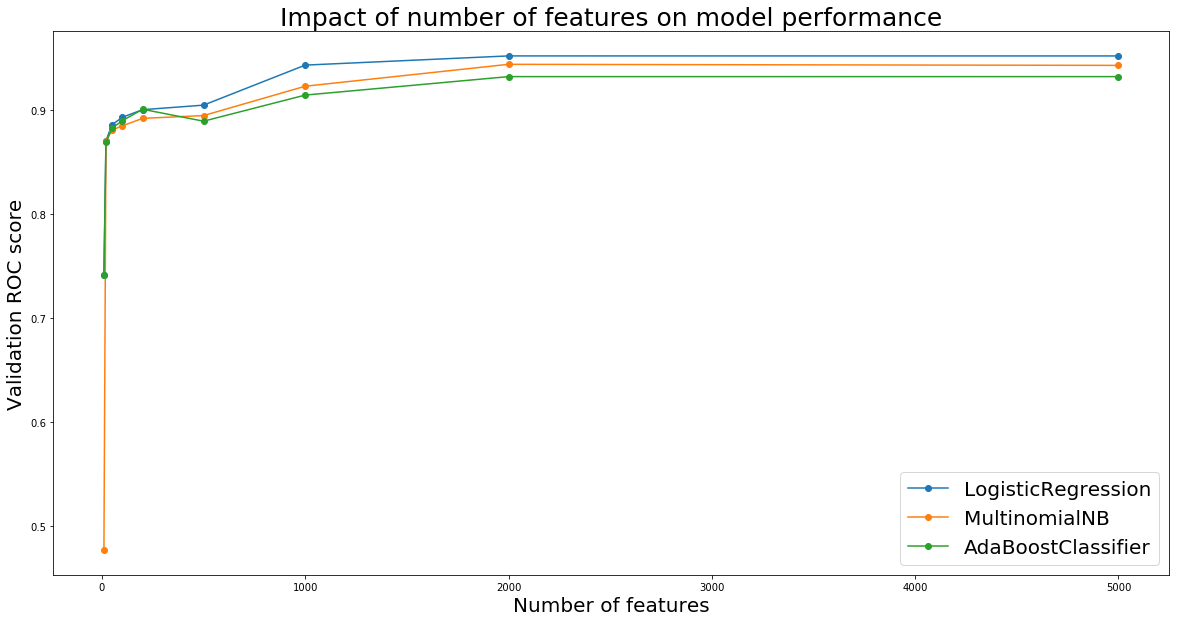

In [98]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [20, 10]
plt.plot('nfeatures','LogisticRegression', data=results, label = "LogisticRegression", marker = 'o')
plt.plot('nfeatures','MultinomialNB', data=results, label = "MultinomialNB", marker = 'o')
plt.plot('nfeatures','AdaBoostClassifier', data=results, label = "AdaBoostClassifier", marker = 'o')
plt.xlabel("Number of features",fontsize=20)
plt.ylabel("Validation ROC score",fontsize=20)
plt.title("Impact of number of features on model performance",fontsize=25)
plt.legend(fontsize=20)
plt.show()


It looks like adding more features beyond 2000 features have minimum impact on model performance. For this data set, it is seems to keep only the 100 best features before hyperparameter optimization.

Let's see what we can do by using class-balanced training set we prepared earlier, and just keep 100 features:

In [100]:
import pickle
from sklearn.metrics import roc_auc_score

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

results_balanced = streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 8.666666666666666 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 4.283333333333333 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.930089232869 it took 0.21666666666666667 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.909096172642 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.905051130916 it took 2.566666666666667 minutes.
********************************************************************************


It looks like having 100 features extracted from a class-balanced training set increases the model performance. This is a good point to start hyperparameter tuning. 

As a last step, let's also look at the impact of changing standardization approach to standardscaler.

In [105]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f) 
nfeatures = 100
featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",StandardScaler(with_mean = False)), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

results_balanced = streamline_classifiers(fpipeline=featureselection_pipeline,
                       nfeatures = nfeatures,X_train = X_train_balanced,y_train = y_train_balanced,
                       X_val = X_val,y_val = y_val)

>>> streamline_classifiers: started exploring model performance using 100 features.
 >>> streamline_classifiers: fitted and transformed X_train. It took: 8.866666666666667 minutes.
Shape of X_train is (835222, 100)
 >>> streamline_classifiers: transformed X_val. It took: 4.6 minutes.
Shape of X_val is (1000000, 100)
 >>> Completed LogisticRegression classifier with an roc score of 0.930163951143 it took 0.31666666666666665 minutes.
********************************************************************************
 >>> Completed MultinomialNB classifier with an roc score of 0.908413806202 it took 0.0 minutes.
********************************************************************************
 >>> Completed AdaBoostClassifier classifier with an roc score of 0.905051130916 it took 2.5166666666666666 minutes.
********************************************************************************


TypeError: A sparse matrix was passed, but dense data is required. Use X.toarray() to convert to a dense numpy array.

Changing scaler has almost no impact. Let's keep MaxAbscaler. Let's transform class-balanced training set and validation sets using this simplified pipeline. 

In [ ]:
import pickle
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import MaxAbsScaler

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced.pkl","rb") as f:
    X_train_balanced = pickle.load(f) 

with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/y_train_balanced.pkl", "rb") as f:
    y_train_balanced = pickle.load(f)
    
# Our validation features and target labels were prepared before:
import pickle
with open("X_val1.pkl","rb") as f:
    X_val1 = pickle.load(f)   
with open("y_val1.pkl","rb") as f:
    y_val1 = pickle.load(f)
        
with open("X_val2.pkl","rb") as f:
    X_val2 = pickle.load(f)       
with open("y_val2.pkl","rb") as f:
    y_val2 = pickle.load(f)      

featureselection_pipeline = Pipeline([
            ("union",FeatureUnion(
                # Note that FeatureUnion() also accepts list of tuples, the first half of each tuple 
                # is the name of the transformer within the FeatureUnion

                transformer_list = [

                    ("numeric_subpipeline",Pipeline([        # Note we have subpipeline branches inside the main pipeline
                        ("parser",get_numeric_data), # Step1: parse the numeric data (note how we avoid () when using FunctionTransformer objects)
                        ("imputer",Imputer()) # Step2: impute any missing data using default (mean), note we don't expect missing values in this case. 
                    ])), # End of: numeric_subpipeline

                    ("text_subpipeline",Pipeline([
                        ("parser",get_text_data), # Step1: parse the text data 
                        ("tokenizer",HashingVectorizer(token_pattern= TOKENS_ALPHANUMERIC, # Step2: use HashingVectorizer for automated tokenization and feature extraction
                                                     ngram_range = (1,1),
                                                     non_negative=True, 
                                                     norm=None, binary=True )), # Note here we use binary=True since our hack is to use tokenization to generate dummy variables  
                        ('dim_red', SelectKBest(k=500)) # Step3: use dimension reduction to select best features 
                    ]))
                ]

            )),# End of step: union, this is the fusion point to main pipeline, all features are numeric at this stage

            # Common steps:

            ("int", SparseInteractions(degree=2)), # Add polynomial interaction terms up to the second degree polynomial
            ("scaler",MaxAbsScaler()), # Scale the features between 0 and 1.       
            ('dim_red2', SelectKBest(k = 100))
        ])# End of: featureselection_pipeline

print("Started training pipeline.")
# Fit the pipeline using the training set
featureselection_pipeline.fit(X_train_balanced,y_train_balanced)
print("Trained pipeline.")

# Save the trained pipeline as 'featureselection_pipeline100.pkl'
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/featureselection_pipeline100.pkl","wb") as f:
    pickle.dump(featureselection_pipeline,f)
print("Saved pipeline.")

# Transform training set
X_train_balanced_trans_100 = featureselection_pipeline.transform(X_train_balanced)
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_train_balanced_trans_100.pkl","wb") as f:
    pickle.dump(X_train_balanced_trans_100,f)
print("Saved X_train_balanced_trans_100." + str(X_train_balanced_trans_100.shape))

# Transform X_val1 set
X_val1_trans_100 = featureselection_pipeline.transform(X_val1)
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_val1_trans_100.pkl","wb") as f:
    pickle.dump(X_val1_trans_100,f)
print("Saved X_val1_trans_100." + str(X_val1_trans_100.shape))

# Transform X_val2 set
X_val2_trans_100 = featureselection_pipeline.transform(X_val2)
with open("/Volumes/Iomega_HDD/2016/Data science/Kaggle/User-click-detection-predictive-modeling/X_val2_trans_100.pkl","wb") as f:
    pickle.dump(X_val2_trans_100,f)
print("Saved X_val2_trans_100." + str(X_val2_trans_100.shape))